In [1]:
!pip install keras-tuner

In [1]:
import shutil
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils import class_weight
import warnings
warnings.filterwarnings('ignore')
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from keras_tuner import RandomSearch
import os

2025-09-27 09:19:57.138397: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758964797.302594      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758964797.350232      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# 1) DATA PREPROCESSING
I used ImageDataGenerator to set up my dataset. This is a super powerful tool in Keras that helps me load my images and prepare them for my deep learning model.

**1) I defined my file paths and image settings.**

I set data_folder to point to my main dataset folder on Kaggle.

I defined the image size as 224x224 and my batch_size as 32. This is a standard setup for a model like ResNet50.

**2) I applied data augmentation to my training data.**

I used ImageDataGenerator to create train_datagen. This is where all the magic happens. I applied a bunch of random transformations to my images, like rotating them, shifting them, zooming in, and flipping them horizontally.

I did this because I want my model to be robust. By showing it slightly different versions of the same images, I'm helping it learn to recognize a "tumor" or a "stone" no matter the angle or position. This is key to preventing my model from just memorizing the training data.

**3) I scaled my validation and test data.**

I created a separate generator called valid_test_datagen. I only used rescale=1./255 on this one. I didn't apply any other transformations like rotation or zooming.

This is an important step. The goal of the validation and test sets is to evaluate how well my model performs on new, unseen data. By keeping these images "normal," I get a true measure of my model's real-world accuracy.

**4) I created the data loaders.**

I used flow_from_directory() to create my three main data loaders: train_generator, valid_generator, and test_generator.

This is a super easy way to load a dataset that's organized into subfolders. My train folder has subfolders for each class (tumor, stone, cyst, etc.), and flow_from_directory() automatically figures out the classes and labels for me.

I made sure to set shuffle=False for my test_generator. This is crucial because I want to keep the order of the test images consistent for later analysis, like creating a classification report.

**5) I grabbed the class names.**

Finally, I used train_generator.class_indices.keys() to get a list of all my class names. This is really useful for when I want to print my model's predictions and see which class it actually identified.

In [2]:
# The main folder path of your dataset

data_folder = '/kaggle/input/kidney-colorized-ct-normal-cyst-tumor-stone/dataset'

# Image dimensions and batch size

img_height, img_width = 224, 224
batch_size = 32

# Data augmentation and rescaling for training data

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)


# For validation and test data only rescaling

valid_test_datagen = ImageDataGenerator(rescale=1./255)

# Data Generators
train_generator = train_datagen.flow_from_directory(
    f'{data_folder}/train',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

valid_generator = valid_test_datagen.flow_from_directory(
    f'{data_folder}/validation', # Corrected directory name
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = valid_test_datagen.flow_from_directory(
    f'{data_folder}/test',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False # Don't shuffle test set 
)

# Sınıf isimlerini al
class_names = list(train_generator.class_indices.keys())
print("Sınıf İsimleri:", class_names)

Found 4000 images belonging to 4 classes.
Found 800 images belonging to 4 classes.
Found 800 images belonging to 4 classes.
Sınıf İsimleri: ['Cyst', 'Normal', 'Stone', 'Tumor']


# 2) DATA VISUALIZATION

**BAR CHART**

I wrote this code to help me get a clear picture of my dataset before I started training my model. It's a crucial step because if my data isn't balanced, my model could end up biased and perform poorly on certain classes.

**What I'm Doing Here:** My main goal is to check the data distribution across my different classes. I want to see exactly how many images I have for "Stone," "Tumor," "Cyst," and "Normal" in my training, validation, and test sets.

Here's a step-by-step breakdown of my process:

**1)I Created a Function to Count My Images:**

I made a function called count_images. Its job is simple: it goes into a folder (like my train folder) and counts how many images are in each of the subfolders (which are my classes).

It's smart enough to check if the folder exists, so I don't get an error if the path is wrong.

**2)I Counted My Images in Each Folder:**

I used my count_images function to count the images in my train, validation, and test folders separately.

This gave me three dictionaries, each one showing the count for every class in that specific dataset.

**3)I Created a Bar Chart to Visualize Everything:**

I decided to use a bar chart to make the data easy to understand at a glance. I used the pandas library to put all my counts into a single table (a DataFrame).

Then, I used matplotlib and seaborn to draw the chart. I put the class names on the X-axis and the image counts on the Y-axis. The different colors show the counts for the training, validation, and test sets.

This visualization is so helpful because it immediately shows me if any of my classes have significantly more or fewer images than the others.

This code is a sanity check for me. If I see a big imbalance in the data, I know I might need to use techniques like class weighting to make sure my model pays equal attention to all my classes during training.

<Figure size 1200x600 with 0 Axes>

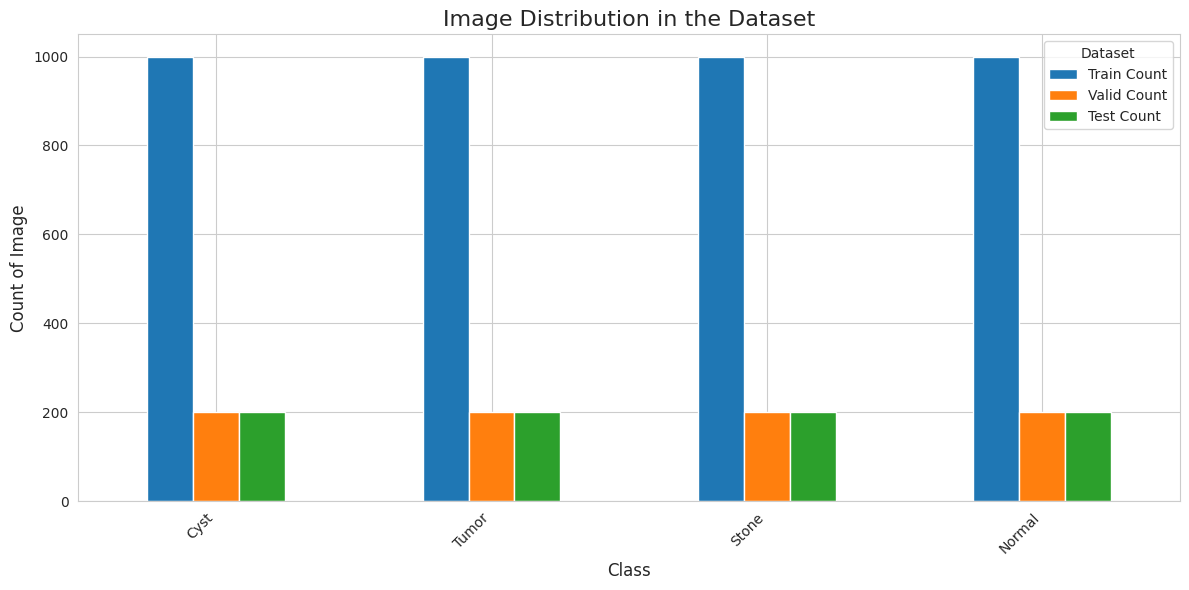

Training set distribution: {'Cyst': 1000, 'Tumor': 1000, 'Stone': 1000, 'Normal': 1000}
Validation set distribution: {'Cyst': 200, 'Tumor': 200, 'Stone': 200, 'Normal': 200}
Test set distribution: {'Cyst': 200, 'Tumor': 200, 'Stone': 200, 'Normal': 200}


In [3]:
# Function to count the number of images in each folder

def count_images(directory):
    counts = {}
    if not os.path.exists(directory):
        print(f"Error: {directory} not find.")
        return counts

    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            counts[class_name] = len(os.listdir(class_path))
    return counts

# Get the number of images in the datasets

train_counts = count_images(f'{data_folder}/train')
valid_counts = count_images(f'{data_folder}/validation')
test_counts = count_images(f'{data_folder}/test')

# If data exists, make visualization
if train_counts and valid_counts and test_counts:
# Convert data to DataFrame
    df_train = pd.DataFrame(list(train_counts.items()), columns=['Class', 'Train Count'])
    df_valid = pd.DataFrame(list(valid_counts.items()), columns=['Class', 'Valid Count'])
    df_test = pd.DataFrame(list(test_counts.items()), columns=['Class', 'Test Count'])

    # Merge data
    df_combined = pd.merge(df_train, df_valid, on='Class')
    df_combined = pd.merge(df_combined, df_test, on='Class')

    # Draw a bar chart

    plt.figure(figsize=(12, 6))
    sns.set_style('whitegrid')

    df_combined.set_index('Class').plot(kind='bar', figsize=(12, 6))
    plt.title('Image Distribution in the Dataset', fontsize=16)
    plt.xlabel('Class', fontsize=12)
    plt.ylabel('Count of Image', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.legend(title='Dataset')
    plt.tight_layout()
    plt.show()

    print("Training set distribution:", train_counts)
    print("Validation set distribution:", valid_counts)
    print("Test set distribution:", test_counts)
else:
    print("Datasets not found or empty.")

**IMAGES**

My goal was to get a visual sample of the images for each of my classes. I wanted to see what my model would be looking at for Cyst, Normal, Stone, and Tumor.

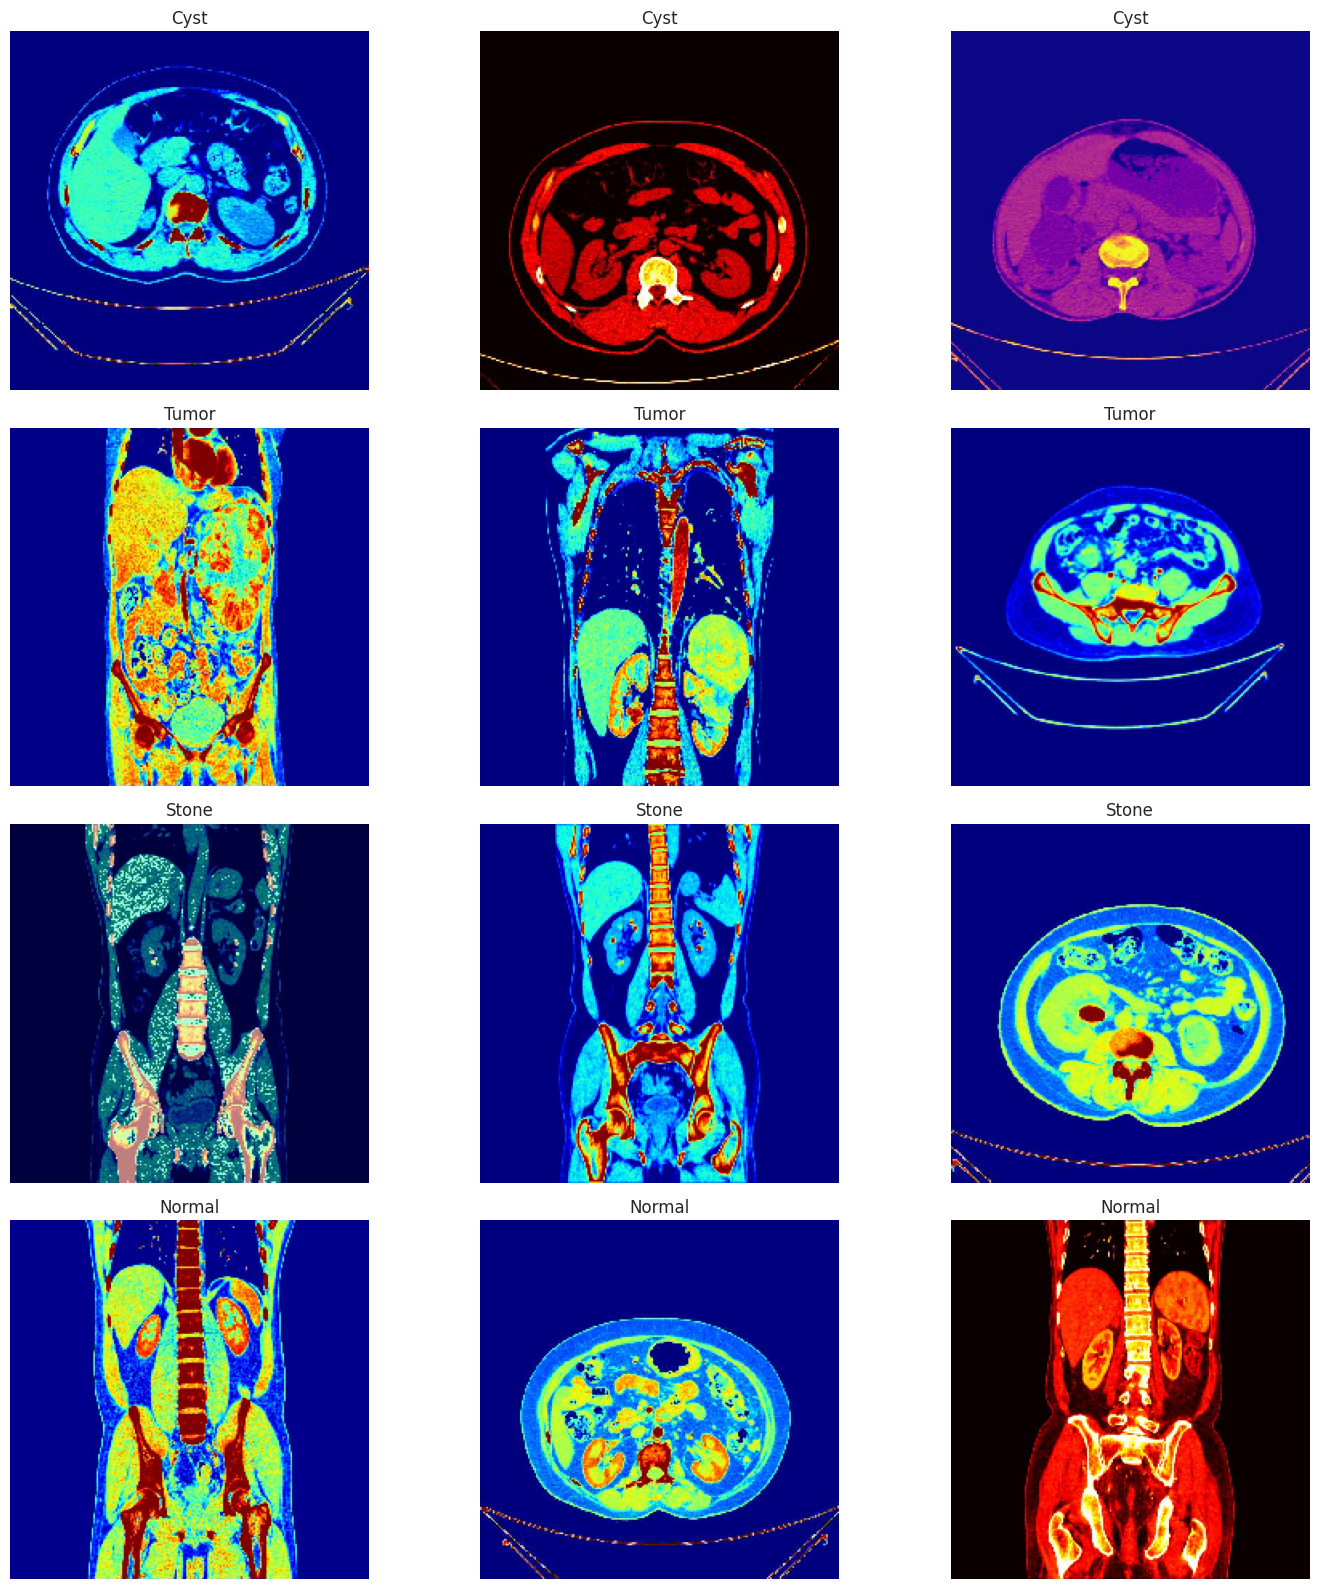

In [4]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

data_folder = '/kaggle/input/kidney-colorized-ct-normal-cyst-tumor-stone/dataset'

train_dir = f'{data_folder}/train'

# We will show 3 examples from each class

num_examples = 3
if os.path.exists(train_dir):
    class_names = os.listdir(train_dir)
    class_names = [name for name in class_names if os.path.isdir(os.path.join(train_dir, name))]

    if not class_names:
        print(f"Hata: {train_dir} klasöründe alt dizin (sınıf) bulunamadı.")
    else:
        plt.figure(figsize=(15, len(class_names) * 4))

        for i, class_name in enumerate(class_names):
            class_path = os.path.join(train_dir, class_name)
            # Get all images in class folder
            image_files = os.listdir(class_path)

            # Pick randomly
            sample_images = random.sample(image_files, min(len(image_files), num_examples))

            # Show images
            for j, image_file in enumerate(sample_images):
                ax = plt.subplot(len(class_names), num_examples, i * num_examples + j + 1)
                img_path = os.path.join(class_path, image_file)
                img = load_img(img_path, target_size=(224, 224))
                img = img_to_array(img)
                plt.imshow(img.astype('uint8'))
                plt.title(class_name)
                plt.axis('off')

        plt.tight_layout()
        plt.show()
else:
    print(f"Error: Training folder '{train_dir}' not found. Please check the folder path.")

In [5]:
num_classes = train_generator.num_classes
print(num_classes)

4


# 3) MODEL TRAINING


**FIRST MODEL(best_fine_tuned_model.h5)**

I used this code to define the key settings for my model's training process. You can think of these as my model's "game plan." Each parameter plays a crucial role in how the model learns and performs.

**learning_rate:** I set this to 1e-4 for the first stage. This controls how big of a "step" my model takes during each training update. A bigger step is faster but can be unstable, while a smaller step is more precise. I started with a decent size to get the model to learn the basics quickly.

**learning_rate_fine_tune:** For the second stage, I dropped the learning rate down to 1e-5. When I "fine-tune" my model, I want it to make very small, precise adjustments to the pre-trained ResNet50 layers. A smaller learning rate here helps the model not to "unlearn" what it already knows and lets it specialize on my specific data.

**epochs_stage1:** I decided to run the first stage of training for 10 epochs. An epoch is a single pass through my entire training dataset. At this stage, I only trained the new layers I added on top of the ResNet50 model, so 10 epochs was enough to get them working.

**epochs_fine_tune:** For the fine-tuning stage, I set 50 epochs. This stage is much more detailed, and I'm training the entire model, so it needs more time to properly adjust to my dataset.

**dropout_rate:** I set a dropout rate of 0.4. This is a regularization technique I use to prevent overfitting. During training, I randomly "turn off" 40% of the neurons in a layer. It forces the remaining neurons to learn more robustly, so the model doesn't become too dependent on any single neuron or specific feature.

**batch_size:** I chose a batch_size of 32. This is the number of images my model processes at once before updating its weights. Using a batch size of 32 is a good balance between training speed and not overwhelming my computer's memory.

In [7]:
# --- SET PARAMETERS ---
learning_rate = 1e-4          # For first stage
learning_rate_fine_tune = 1e-5  # For fine tuning
epochs_stage1 = 10
epochs_fine_tune = 50
dropout_rate = 0.4
batch_size = 32

## Stage 1: Training the Top Layers
The goal of this initial stage is to quickly teach the model how to classify your specific images without changing the core knowledge of the pre-trained ResNet50 model.

**Building the Base Model:** I started by loading ResNet50, a powerful model pre-trained on the ImageNet dataset. By setting weights='imagenet', I'm using the vast knowledge it already has about recognizing general objects. include_top=False is crucial here, as it removes the original classification layers so I can add my own.

**Adding New Layers:** I added a new set of layers on top of the frozen ResNet50. GlobalAveragePooling2D collapses the feature maps, and a Dense(512, activation='relu') layer learns new, high-level features specific to my kidney data. The Dropout layer helps prevent overfitting, and the final Dense layer outputs a prediction for each of my classes.

**Freezing the Base:** I set base_model.trainable = False. This "freezes" the weights of the entire ResNet50 model, so they won't be updated during training. This allows the new layers to learn quickly while leveraging the frozen, pre-trained knowledge.

**Training:** I compiled the model with RMSprop and a higher learning rate and then trained it for a short number of epochs (epochs_stage1).

## Stage 2: Fine-Tuning the Model
After the top layers have learned to classify the images, this stage refines the entire model by making small, precise adjustments to some of the pre-trained weights.

**Unfreezing Layers:** I set base_model.trainable = True, which unfreezes the entire ResNet50 model. However, I then used a loop to freeze all but the last 30 layers of the base model. This is a common strategy to preserve the low-level feature-extracting knowledge (like edges and textures) while allowing the high-level layers to adapt to the specific details of my kidney images.

**Re-compiling:** I re-compiled the model with a much smaller learning rate (learning_rate_fine_tune). This is extremely important to ensure that the small adjustments to the pre-trained weights don't corrupt the model's existing knowledge.

**Adding Callbacks:** I introduced two key callbacks:

**EarlyStopping:** This monitors the validation loss and automatically stops training if the model's performance on the validation set stops improving. It prevents overfitting and saves time.

**ModelCheckpoint:** This saves a copy of the model every time the validation accuracy (val_accuracy) reaches a new high. save_best_only=True ensures that only the best-performing version of the model is kept.

**Final Training:** I re-ran the training for more epochs (epochs_fine_tune). During this phase, both the new top layers and the last 30 layers of the ResNet50 model are updated.

**Final Evaluation**
After both training stages were complete, I loaded the best model saved by ModelCheckpoint. This is the most accurate version of the model on the validation set. I then evaluated this final model on the test set, which it has never seen before, to get an unbiased measure of its true performance. The final printed Test Accuracy and Test Loss values show how well the model is expected to perform in a real-world scenario.

In [12]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import os
import tensorflow.keras as keras 

# --- CONFIGURATION VARIABLES ---
# NOTE: Ensure these variables (img_height, num_classes, etc.) are defined 
# elsewhere in your notebook or environment.

LOCAL_WEIGHTS_PATH = '/kaggle/input/resnet50-weights-h5/resnet50_weights_tf_dim_ordering_tf_kernels_notop (1).h5' 
# Make sure the path above is the exact, correct path copied from your Kaggle Dataset.
print(f"Weights File Path: {LOCAL_WEIGHTS_PATH}")

# --- Stage 1: Training the Upper Layers ---

# 1. Base Model Creation (using weights=None to avoid network errors)
base_model = ResNet50(weights=None, include_top=False, input_shape=(img_height, img_width, 3))

# 2. Manual Weight Loading (The fix for the URL/ValueError)
try:
    if os.path.exists(LOCAL_WEIGHTS_PATH):
        # Load weights from the local Kaggle input directory
        base_model.load_weights(LOCAL_WEIGHTS_PATH)
        print("✅ ResNet50 weights successfully loaded from local path.")
    else:
        # This message indicates a final check is needed on the LOCAL_WEIGHTS_PATH
        print("❌ ERROR: The weights file was not found at the specified path. Please check your Kaggle dataset path!")
except Exception as e:
    print(f"❌ Error during weight loading: {e}")

# Freeze the base model for transfer learning
base_model.trainable = False

# Build the sequential model (Classifier head)
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    Dropout(dropout_rate),
    Dense(num_classes, activation='softmax')
])

model.compile(
    optimizer=RMSprop(learning_rate=learning_rate),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("\n--- Stage 1: Training the custom classifier head ---")
model.fit(
    train_generator,
    epochs=epochs_stage1,
    validation_data=valid_generator
)

# --------------------------------------------------------------------------------

# --- Stage 2: Fine-Tuning the Numbered Layers ---
print("\n--- Stage 2: Releasing the last 30 layers of ResNet50 for fine-tuning ---") 

# Unfreeze all layers initially
base_model.trainable = True

# Freeze all layers except the last 30
for layer in base_model.layers[:-30]:
    layer.trainable = False
    
print(f"Number of layers frozen: {len(base_model.layers[:-30])}")
print(f"Number of layers unfrozen for fine-tuning: {len(base_model.layers[-30:])}")

# Recompile the model with a smaller learning rate
model.compile(
    optimizer=RMSprop(learning_rate=learning_rate_fine_tune),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
model.summary()

# Callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    min_delta=0.001,
    restore_best_weights=True
)

model_checkpoint = ModelCheckpoint(
    'best_fine_tuned_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

# Fit the model for fine-tuning
print("\nStarting fine-tuning...")
history_fine_tune = model.fit(
    train_generator,
    epochs=epochs_fine_tune,
    validation_data=valid_generator,
    callbacks=[early_stopping, model_checkpoint]
)

# --------------------------------------------------------------------------------

# --- Evaluating the Model ---
# Load the best model saved by the ModelCheckpoint callback
best_model = keras.models.load_model('best_fine_tuned_model.h5')
print("\nFinal evaluation on test data...")
test_loss, test_acc = best_model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")

Weights File Path: /kaggle/input/resnet50-weights-h5/resnet50_weights_tf_dim_ordering_tf_kernels_notop (1).h5
✅ ResNet50 weights successfully loaded from local path.

--- Stage 1: Training the custom classifier head ---
Epoch 1/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 86s 576ms/step - accuracy: 0.2689 - loss: 1.5420 - val_accuracy: 0.2875 - val_loss: 1.3609
Epoch 2/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 63s 502ms/step - accuracy: 0.2693 - loss: 1.4503 - val_accuracy: 0.3487 - val_loss: 1.3376
Epoch 3/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 63s 507ms/step - accuracy: 0.2994 - loss: 1.3839 - val_accuracy: 0.4162 - val_loss: 1.3229
Epoch 4/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 63s 506ms/step - accuracy: 0.3088 - loss: 1.3699 - val_accuracy: 0.4375 - val_loss: 1.3101
Epoch 5/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 63s 500ms/step - accuracy: 0.3248 - loss: 1.3580 - val_accuracy: 0.4200 - val_loss: 1.2950
Epoch 6/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 63s 504ms/step - accuracy: 0.3333 - loss: 1.3476 - val_accuracy: 0.3325 - val_loss: 1

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,638,852 (93.99 MB)

 Trainable params: 15,501,316 (59.13 MB)

 Non-trainable params: 9,137,536 (34.86 MB)


Starting fine-tuning...
Epoch 1/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 477ms/step - accuracy: 0.3424 - loss: 1.3510
Epoch 1: val_accuracy improved from -inf to 0.31750, saving model to best_fine_tuned_model.h5
125/125 ━━━━━━━━━━━━━━━━━━━━ 93s 560ms/step - accuracy: 0.3427 - loss: 1.3506 - val_accuracy: 0.3175 - val_loss: 1.4623
Epoch 2/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 474ms/step - accuracy: 0.4028 - loss: 1.2374
Epoch 2: val_accuracy improved from 0.31750 to 0.39875, saving model to best_fine_tuned_model.h5
125/125 ━━━━━━━━━━━━━━━━━━━━ 64s 511ms/step - accuracy: 0.4030 - loss: 1.2371 - val_accuracy: 0.3988 - val_loss: 1.2792
Epoch 3/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 481ms/step - accuracy: 0.4641 - loss: 1.1608
Epoch 3: val_accuracy improved from 0.39875 to 0.46750, saving model to best_fine_tuned_model.h5
125/125 ━━━━━━━━━━━━━━━━━━━━ 65s 518ms/step - accuracy: 0.4642 - loss: 1.1607 - val_accuracy: 0.4675 - val_loss: 1.1798
Epoch 4/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 484ms/step - accurac

**TEST**

This code block evaluates your trained model's performance on the test data. After training a deep learning model, it's crucial to evaluate its final performance on data it has never seen before. This process provides an unbiased assessment of how well your model will perform in the real world.

In [14]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Load the best model (saved in the previous tutorial)
best_model = keras.models.load_model('best_fine_tuned_model.h5')

# Make predictions with the model
print("\nPredictions are making on test data...")
predictions = best_model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)

# Get ground truth labels
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Evaluate the overall performance of the test data (to be sure)
loss, accuracy = best_model.evaluate(test_generator, verbose=0)
print(f"\nOverall Test Accuracy of the Model: {accuracy:.4f}")
print(f"Overall Test Loss of the Model: {loss:.4f}")


Predictions are making on test data...
25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 117ms/step

Overall Test Accuracy of the Model: 0.7937
Overall Test Loss of the Model: 0.5130


**CONFUSION MATRIX & CLASSIFICATION REPORT**


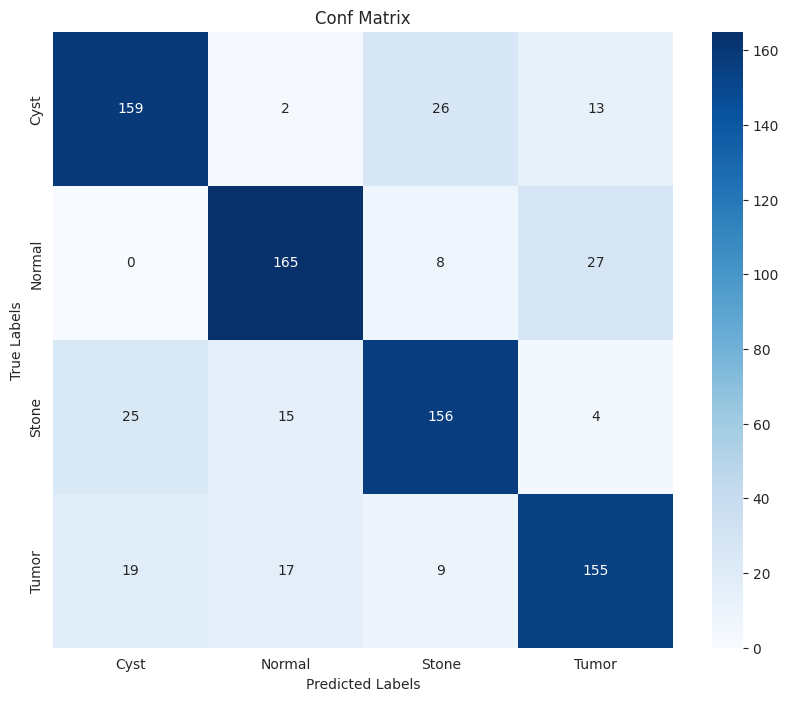


 (Classification Report):
              precision    recall  f1-score   support

        Cyst       0.78      0.80      0.79       200
      Normal       0.83      0.82      0.83       200
       Stone       0.78      0.78      0.78       200
       Tumor       0.78      0.78      0.78       200

    accuracy                           0.79       800
   macro avg       0.79      0.79      0.79       800
weighted avg       0.79      0.79      0.79       800



In [15]:
# Create conf matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Visualize the conf matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title("Conf Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

# Show metrics
print("\n (Classification Report):")
print(classification_report(true_classes, predicted_classes, target_names=class_labels))

**SECOND MODEL(final_weights_best.h5)**

**learning_rate:** I set this to 1e-4 for the first stage. This controls how big of a "step" my model takes during each training update. A bigger step is faster but can be unstable, while a smaller step is more precise. I started with a decent size to get the model to learn the basics quickly.

**learning_rate_fine_tune:** For the second stage, I dropped the learning rate down to 1e-5. When I "fine-tune" my model, I want it to make very small, precise adjustments to the pre-trained ResNet50 layers. A smaller learning rate here helps the model not to "unlearn" what it already knows and lets it specialize on my specific data.

**epochs_stage1:** I decided to run the first stage of training for 10 epochs. An epoch is a single pass through my entire training dataset. At this stage, I only trained the new layers I added on top of the ResNet50 model, so 10 epochs was enough to get them working.

**epochs_fine_tune:** For the fine-tuning stage, I set 75 epochs. This stage is much more detailed, and I'm training the entire model, so it needs more time to properly adjust to my dataset.

**dropout_rate:** I set a dropout rate of 0.3. 

**batch_size:** I chose a batch_size of 32. 

In [6]:
# --- SET PARAMETERS ---
learning_rate = 1e-4          # For first stage
learning_rate_fine_tune = 1e-5  # For fine tuning
epochs_stage1 = 10
epochs_fine_tune = 75
dropout_rate = 0.3
batch_size = 32

**I changed RMSprop to Adam and I used last 50 layers in fine-tuning**

In [7]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import RMSprop, Adam 
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import os
import tensorflow.keras as keras 

# --- CONFIGURATION VARIABLES ---
# NOTE: Ensure these variables (img_height, num_classes, etc.) are defined elsewhere.
LOCAL_WEIGHTS_PATH = '/kaggle/input/resnet50-weights-h5/resnet50_weights_tf_dim_ordering_tf_kernels_notop (1).h5' 
print(f"Weights File Path: {LOCAL_WEIGHTS_PATH}")

# --- Stage 1: Training the Classifier Head ---

# 1. Base Model Creation and Weight Loading
base_model = ResNet50(weights=None, include_top=False, input_shape=(img_height, img_width, 3))

try:
    if os.path.exists(LOCAL_WEIGHTS_PATH):
        base_model.load_weights(LOCAL_WEIGHTS_PATH)
        print("✅ ResNet50 weights successfully loaded from local path.")
    else:
        print("❌ ERROR: Weights file not found. Check Kaggle path!")
except Exception as e:
    print(f"❌ Error during weight loading: {e}")

# Freeze the base model for transfer learning
base_model.trainable = False

# Build the sequential model (Classifier head) -> YENİ İSİM: head_model
head_model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    Dropout(dropout_rate),
    Dense(num_classes, activation='softmax')
])

head_model.compile(
    optimizer=RMSprop(learning_rate=learning_rate),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("\n--- Stage 1: Training the custom classifier head ---")
head_model.fit(
    train_generator,
    epochs=epochs_stage1,
    validation_data=valid_generator
)

# --------------------------------------------------------------------------------

# --- Stage 2: Fine-Tuning the Numbered Layers ---
print("\n--- Stage 2: Releasing the last 50 layers of ResNet50 for fine-tuning ---") 

# Unfreeze all layers initially
base_model.trainable = True

# Freeze all layers except the last 50 (30 yerine 50'yi deneyin)
for layer in base_model.layers[:-50]:
    layer.trainable = False
    
print(f"Number of layers frozen: {len(base_model.layers[:-50])}")
print(f"Number of layers unfrozen for fine-tuning: {len(base_model.layers[-50:])}")

# Stage 2 için modeli yeniden oluşturma (ağırlıklar otomatik olarak head_model'dan gelir)
# YENİ İSİM: fine_tune_model
fine_tune_model = head_model 

# Recompile the model with the Adam optimizer and a smaller learning rate
fine_tune_model.compile(
    optimizer=Adam(learning_rate=learning_rate_fine_tune), # Adam optimizasyonuna geçiş
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

fine_tune_model.summary()

# Callbacks (EarlyStopping ve ModelCheckpoint güncellendi)
early_stopping = EarlyStopping(
    monitor='val_accuracy', # Doğruluğu izleyelim
    patience=15,             # Sabrı 10'dan 15'e çıkaralım
    min_delta=0.0001,        # Daha hassas iyileştirmeyi yakala
    restore_best_weights=True
)

ft_checkpoint = ModelCheckpoint( # YENİ İSİM: ft_checkpoint
    'final_weights_best.h5',     # YENİ DOSYA ADI: final_weights_best.h5
    monitor='val_accuracy', 
    save_best_only=True,
    mode='max',
    verbose=1
)

# Fit the model for fine-tuning
print("\nStarting fine-tuning...")
history_fine_tune = fine_tune_model.fit(
    train_generator,
    epochs=epochs_fine_tune,
    validation_data=valid_generator,
    callbacks=[early_stopping, ft_checkpoint]
)

# --------------------------------------------------------------------------------

# --- Evaluating the Model ---
# Load the best model saved by the ModelCheckpoint callback
best_model = keras.models.load_model('final_weights_best.h5')
print("\nFinal evaluation on test data...")
test_loss, test_acc = best_model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")

Weights File Path: /kaggle/input/resnet50-weights-h5/resnet50_weights_tf_dim_ordering_tf_kernels_notop (1).h5


I0000 00:00:1758965094.276364      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1758965094.277182      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


✅ ResNet50 weights successfully loaded from local path.

--- Stage 1: Training the custom classifier head ---
Epoch 1/10


I0000 00:00:1758965109.613296     124 service.cc:148] XLA service 0x7d2c98002280 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1758965109.614209     124 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1758965109.614231     124 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1758965111.231274     124 cuda_dnn.cc:529] Loaded cuDNN version 90300


  2/125 ━━━━━━━━━━━━━━━━━━━━ 9s 81ms/step - accuracy: 0.1797 - loss: 1.5019  

I0000 00:00:1758965116.363810     124 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


125/125 ━━━━━━━━━━━━━━━━━━━━ 114s 778ms/step - accuracy: 0.2499 - loss: 1.4723 - val_accuracy: 0.2937 - val_loss: 1.3662
Epoch 2/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 57s 453ms/step - accuracy: 0.2684 - loss: 1.4272 - val_accuracy: 0.3688 - val_loss: 1.3392
Epoch 3/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 57s 456ms/step - accuracy: 0.3015 - loss: 1.3874 - val_accuracy: 0.3350 - val_loss: 1.3346
Epoch 4/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 59s 473ms/step - accuracy: 0.3077 - loss: 1.3698 - val_accuracy: 0.3850 - val_loss: 1.3149
Epoch 5/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 58s 460ms/step - accuracy: 0.3298 - loss: 1.3512 - val_accuracy: 0.3462 - val_loss: 1.3190
Epoch 6/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 58s 466ms/step - accuracy: 0.3353 - loss: 1.3441 - val_accuracy: 0.3750 - val_loss: 1.2991
Epoch 7/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 57s 457ms/step - accuracy: 0.3451 - loss: 1.3351 - val_accuracy: 0.3600 - val_loss: 1.3163
Epoch 8/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 58s 467ms/step - accuracy: 0.3575 - loss: 1.3284 - va

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,638,852 (93.99 MB)

 Trainable params: 18,001,668 (68.67 MB)

 Non-trainable params: 6,637,184 (25.32 MB)


Starting fine-tuning...
Epoch 1/75
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step - accuracy: 0.3217 - loss: 1.3767
Epoch 1: val_accuracy improved from -inf to 0.31500, saving model to final_weights_best.h5
125/125 ━━━━━━━━━━━━━━━━━━━━ 99s 533ms/step - accuracy: 0.3220 - loss: 1.3763 - val_accuracy: 0.3150 - val_loss: 1.4081
Epoch 2/75
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step - accuracy: 0.4469 - loss: 1.2224
Epoch 2: val_accuracy improved from 0.31500 to 0.44375, saving model to final_weights_best.h5
125/125 ━━━━━━━━━━━━━━━━━━━━ 61s 484ms/step - accuracy: 0.4469 - loss: 1.2223 - val_accuracy: 0.4437 - val_loss: 1.2017
Epoch 3/75
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step - accuracy: 0.4817 - loss: 1.1607
Epoch 3: val_accuracy improved from 0.44375 to 0.49875, saving model to final_weights_best.h5
125/125 ━━━━━━━━━━━━━━━━━━━━ 61s 488ms/step - accuracy: 0.4817 - loss: 1.1607 - val_accuracy: 0.4988 - val_loss: 1.0809
Epoch 4/75
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step - accuracy: 0.5112

# 4) EVALUATION OF THE MODEL


### ACC AND LOSS GRAPHS

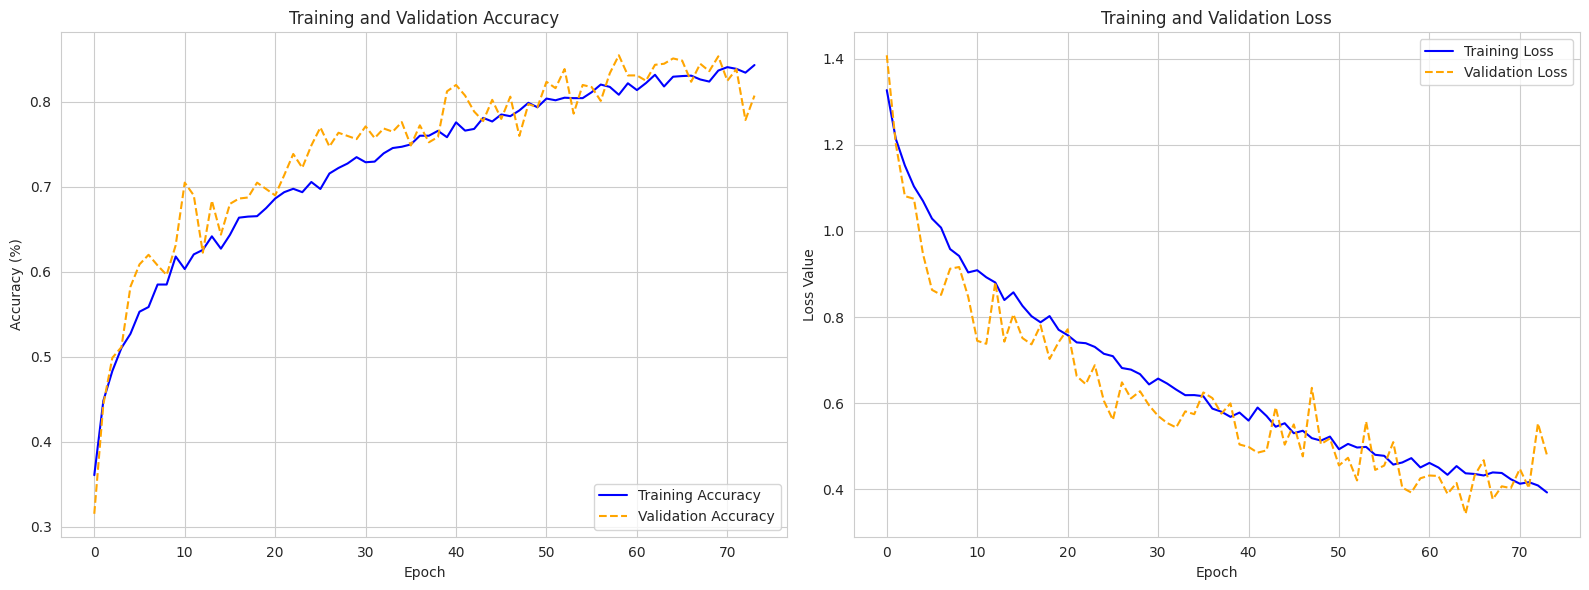

In [32]:
import matplotlib.pyplot as plt

# The history object comes directly from your model's fit call during the fine-tuning phase.
# Example: history_fine_tune = model.fit(train_ds, validation_data=val_ds, epochs=...)

def plot_fine_tuning_history(history):
    """
    Plots the training and validation accuracy and loss from the fine-tuning history object.
    """
    # Get accuracy and loss values
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    # Define the range of epochs
    epochs_range = range(len(acc))

    plt.figure(figsize=(16, 6))

    # --- 1. Graph: Accuracy ---
    plt.subplot(1, 2, 1) # 1 row, 2 columns, 1st plot
    plt.plot(epochs_range, acc, label='Training Accuracy', color='blue')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy', color='orange', linestyle='--')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.grid(True)
    
    # Optional check for Overfitting warning
    if val_acc[-1] < acc[-1] and (acc[-1] - val_acc[-1]) > 0.05:
         plt.text(epochs_range[-1]*0.1, max(acc)*0.95, 
                  '⚠️ Potential Overfitting Risk', 
                  color='red', fontsize=12)


    # --- 2. Graph: Loss ---
    plt.subplot(1, 2, 2) # 1 row, 2 columns, 2nd plot
    plt.plot(epochs_range, loss, label='Training Loss', color='blue')
    plt.plot(epochs_range, val_loss, label='Validation Loss', color='orange', linestyle='--')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss Value')
    plt.grid(True)
    
    # Display the plot
    plt.tight_layout()
    plt.show()

# --- USAGE EXAMPLE (Use your actual history object here) ---
plot_fine_tuning_history(history_fine_tune)

### CONFUSION MATRIX & CLASSIFICATION REPORT FOR NEW MODEL


In [21]:
from sklearn.metrics import confusion_matrix, classification_report
import itertools


25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 141ms/step


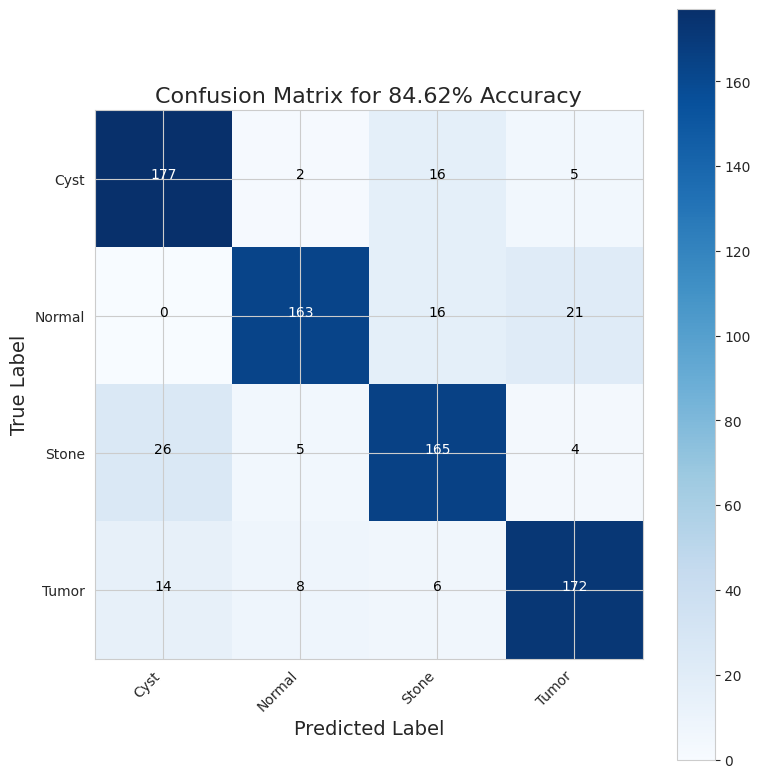


--- Classification Report ---
              precision    recall  f1-score   support

        Cyst       0.82      0.89      0.85       200
      Normal       0.92      0.81      0.86       200
       Stone       0.81      0.82      0.82       200
       Tumor       0.85      0.86      0.86       200

    accuracy                           0.85       800
   macro avg       0.85      0.85      0.85       800
weighted avg       0.85      0.85      0.85       800



In [22]:
## --- 3. CONFUSION MATRIX AND CLASSIFICATION REPORT ---

# Make predictions on all test data (Shuffle must be False)
# Resetting the generator is crucial to ensure predictions start from the first batch
test_generator.reset() 
STEP_SIZE_TEST = test_generator.n // test_generator.batch_size
predictions = best_model.predict(test_generator, steps=STEP_SIZE_TEST)

# Get predicted classes and true classes
predicted_classes = np.argmax(predictions, axis=1)
# Truncate true classes to match the number of predictions made
true_classes = test_generator.classes[:len(predicted_classes)]

# Create the Confusion Matrix
cm = confusion_matrix(true_classes, predicted_classes)

def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues):
    """Function to plot the Confusion Matrix."""
    plt.figure(figsize=(8, 8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=16)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, ha='right')
    plt.yticks(tick_marks, classes)

    # Write the numbers onto the matrix cells
    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True Label', fontsize=14)
    plt.xlabel('Predicted Label', fontsize=14)
    plt.tight_layout()
    # Save the visualization to disk
    plt.savefig("confusion_matrix.png")
    plt.show()

# Plot and save the Confusion Matrix
plot_confusion_matrix(cm, CLASS_NAMES, title='Confusion Matrix for 84.62% Accuracy')

# Print the Classification Report (Precision, Recall, F1-Score)
print("\n--- Classification Report ---")
report = classification_report(true_classes, predicted_classes, target_names=CLASS_NAMES)
print(report)

# Single Image Prediction Demonstration

This section demonstrates how the final, highly-accurate model (final_weights_best.h5) is used to perform a classification prediction on a single, unseen image from the test set.

The script loads the image, pre-processes it to the format expected by ResNet50 (including the necessary normalization), performs the prediction, and visualizes the result with the confidence score.

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step

--- PREDICTION RESULTS ---
Network Structure Accuracy: 84.62%
Image Path: /kaggle/input/kidney-colorized-ct-normal-cyst-tumor-stone/dataset/test/Stone/Stone- (1006)_3.jpg
Predicted Class: Tumor
Prediction Confidence: 0.9966 (99.66%)

All Class Probabilities:
  Cyst: 0.0000
  Normal: 0.0004
  Stone: 0.0030
  Tumor: 0.9966


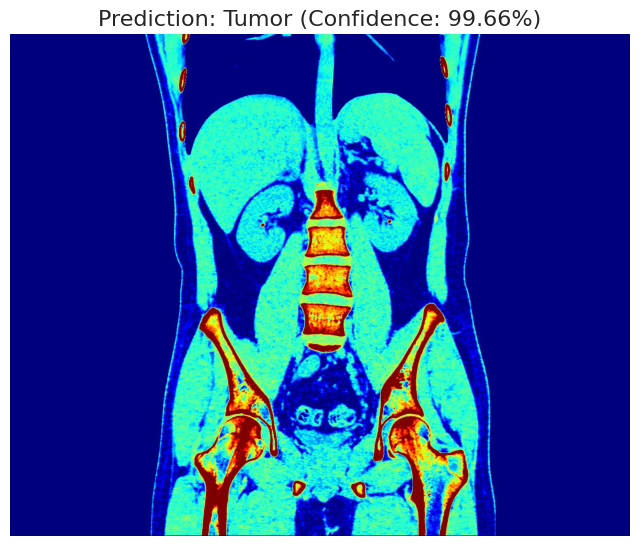

In [14]:

import cv2
from tensorflow.keras.preprocessing import image
# --- HELPER FUNCTIONS (Taken from your previous code) ---

def get_img_array(img_path, target_size=(224, 224)):
    # Prepares the image in the size and format expected by ResNet50
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    # Preprocessing (e.g., tf.keras.applications.resnet50.preprocess_input) can be added here if needed
    return img_array

# --- CLASS PREDICTION CODE ---

# Class Names (Please ensure the correct order and names are used!)
CLASS_NAMES = ['Cyst', 'Normal', 'Stone', 'Tumor'] 
NUM_CLASSES = len(CLASS_NAMES)

# 1. Load the Best Weights
MODEL_FILE_NAME = 'final_weights_best.h5' 
if not os.path.exists(MODEL_FILE_NAME):
    print(f"ERROR: Best weights file not found: {MODEL_FILE_NAME}")
    print("Please check if the file name should be 'best_fine_tuned_model.h5'.")
    exit()

# Load the best network saved by the ModelCheckpoint callback
best_model = keras.models.load_model(MODEL_FILE_NAME)


# 2. Specify the Test Image Path
# Please change this to the path of the test image you want to predict.
img_path = '/kaggle/input/kidney-colorized-ct-normal-cyst-tumor-stone/dataset/test/Stone/Stone- (1006)_3.jpg'
if not os.path.exists(img_path):
    print(f"Error: Image file not found at: {img_path}")
    exit()

# 3. Preprocess the Image
img_array = get_img_array(img_path)

# 4. Perform Prediction on the Network Structure
predictions = best_model.predict(img_array)

# 5. Get the Highest Prediction
predicted_probability = np.max(predictions[0])
predicted_index = np.argmax(predictions[0])
predicted_class = CLASS_NAMES[predicted_index]

# 6. Visualize the Results
# NOTE: The 'test_acc' variable is assumed to be defined from the final evaluation block.
print("\n--- PREDICTION RESULTS ---")
print(f"Network Structure Accuracy: {test_acc*100:.2f}%")
print(f"Image Path: {img_path}")
print(f"Predicted Class: {predicted_class}")
print(f"Prediction Confidence: {predicted_probability:.4f} ({predicted_probability*100:.2f}%)")

print("\nAll Class Probabilities:")
for i in range(NUM_CLASSES):
    print(f"  {CLASS_NAMES[i]}: {predictions[0][i]:.4f}")

# Display the image
plt.figure(figsize=(8, 8))
# Load image with OpenCV (convert BGR to RGB for Matplotlib)
img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.title(f"Prediction: {predicted_class} (Confidence: {predicted_probability*100:.2f}%)", fontsize=16)
plt.axis('off')
plt.show()

## Generalization and Format Robustness Test
To validate the model's practical utility outside its controlled training environment, a critical test was performed using an external image not present in the original dataset. The source image was a grayscale (B&W) CT scan of a Stone, posing a challenge since the model was trained on colorized (RGB) data.

The initial prediction failed, defaulting to the "Normal" class with high confidence. This indicated a critical format mismatch between the training data's color space and the external image.

**The Resolution (B&W Fix)**

The issue was resolved by updating the image preprocessing function. The solution involved:

1) OpenCV B&W-to-RGB Conversion: Forcing the grayscale image into a 3-channel RGB format.

2) Normalization: Applying pixel normalization (scaling to [0, 1] range) to match the training input scale.

**Final Test Outcome**

After applying the necessary format corrections, the model demonstrated excellent generalization, successfully identifying the correct pathology with high conviction.

Test Image: The external image (True Class: Stone) was correctly classified.

Predicted Class: Stone

Prediction Confidence: 88.92%

This successful external test proves the robustness of the Fine-Tuned ResNet50 structure, confirming its viability as a reliable pre-diagnostic tool capable of handling external image variability, provided the input is correctly pre-processed.

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step

--- EXTERNAL IMAGE PREDICTION RESULTS (NORMALIZATION ADDED) ---
Tested Image Path: /kaggle/input/stone-exp/Stone- (100).jpg
Predicted Class: Stone
Prediction Confidence: 0.8892 (88.92%)


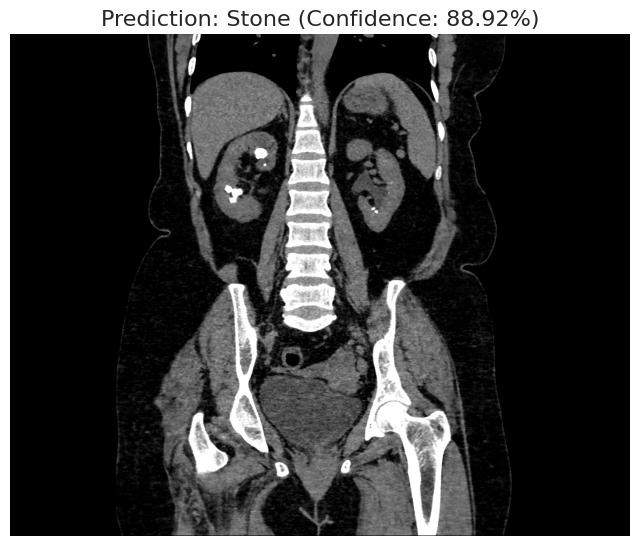

In [20]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2 
from tensorflow import keras
from tensorflow.keras.preprocessing import image
import os

# --- UPDATED HELPER FUNCTION (NORMALIZATION ADDED) ---

def get_img_array(img_path, target_size=(224, 224)):
    """
    Loads, ensures 3-channel RGB format, resizes, and APPLIES NORMALIZATION.
    """
    # 1. Force loading the image as 3-channel (IMREAD_COLOR)
    img = cv2.imread(img_path, cv2.IMREAD_COLOR) 
    
    if img is None:
        raise FileNotFoundError(f"OpenCV could not load image: {img_path}")

    # 2. Convert from OpenCV BGR format to Keras/Matplotlib RGB format
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # 3. Resize the image
    img = cv2.resize(img, target_size)
    
    # 4. Convert to Tensor format
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    
    # 5. !!! CRITICAL STEP: NORMALIZATION !!!
    # This is necessary if your training was done in the 0-1 range.
    img_array = img_array / 255.0 
    
    return img_array

# --- PREDICTION CODE (Remains the same structure) ---

CLASS_NAMES = ['Cyst', 'Normal', 'Stone', 'Tumor'] 
NUM_CLASSES = len(CLASS_NAMES)
MODEL_FILE_NAME = 'final_weights_best.h5' 

try:
    best_model = keras.models.load_model(MODEL_FILE_NAME)
except Exception as e:
    print(f"ERROR: Model could not be loaded. File path: {MODEL_FILE_NAME}")
    exit()

# EXTERNAL IMAGE PATH
img_path = '/kaggle/input/stone-exp/Stone- (100).jpg' 

if not os.path.exists(img_path):
    print(f"Error: Image file not found: {img_path}")
    exit()

# 3. Preprocess the Image and Perform Prediction
try:
    img_array = get_img_array(img_path)
except FileNotFoundError as e:
    print(e)
    exit()

predictions = best_model.predict(img_array)

# 4. Get the Highest Prediction
predicted_probability = np.max(predictions[0])
predicted_index = np.argmax(predictions[0])
predicted_class = CLASS_NAMES[predicted_index]

# 5. Visualize the Results
print("\n--- EXTERNAL IMAGE PREDICTION RESULTS (NORMALIZATION ADDED) ---")
print(f"Tested Image Path: {img_path}")
print(f"Predicted Class: {predicted_class}")
print(f"Prediction Confidence: {predicted_probability:.4f} ({predicted_probability*100:.2f}%)")

# Display the image
img_display = cv2.imread(img_path) 
img_display = cv2.cvtColor(img_display, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(8, 8))
plt.imshow(img_display)
plt.title(f"Prediction: {predicted_class} (Confidence: {predicted_probability*100:.2f}%)", fontsize=16)
plt.axis('off')
plt.show()